In [3]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import random
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torchvision.transforms as transforms
import torch.optim as optim
from skimage import io
import torch.nn.functional as F
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, confusion_matrix

In [35]:
data_dir="/kaggle/input/medical-scan-classification-dataset/Alzheimer/Alzheimer/MRI"
classes=["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
labels={"id":[], "label":[]}
for classname in classes:
    for image in os.listdir(data_dir+f"/{classname}"):
        labels["id"].append(data_dir+f"/{classname}/{image}")
        labels["label"].append(classname)
labels=pd.DataFrame(labels)
labels.to_csv("labels.csv", index=False)

In [36]:
labels=pd.read_csv("/kaggle/working/labels.csv")
labels

,id,label
0,/kaggle/input/medical-scan-classification-data...,MildDemented
1,/kaggle/input/medical-scan-classification-data...,MildDemented
2,/kaggle/input/medical-scan-classification-data...,MildDemented
3,/kaggle/input/medical-scan-classification-data...,MildDemented
4,/kaggle/input/medical-scan-classification-data...,MildDemented
...,...,...
35197,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
35198,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
35199,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
35200,/kaggle/input/medical-scan-classification-data...,VeryMildDemented


In [37]:
label_count=labels.groupby(by="label", as_index=False).count().sort_values(by="id", ascending=False)
label_count

,label,id
2,NonDemented,12800
3,VeryMildDemented,11200
1,ModerateDemented,6528
0,MildDemented,4674


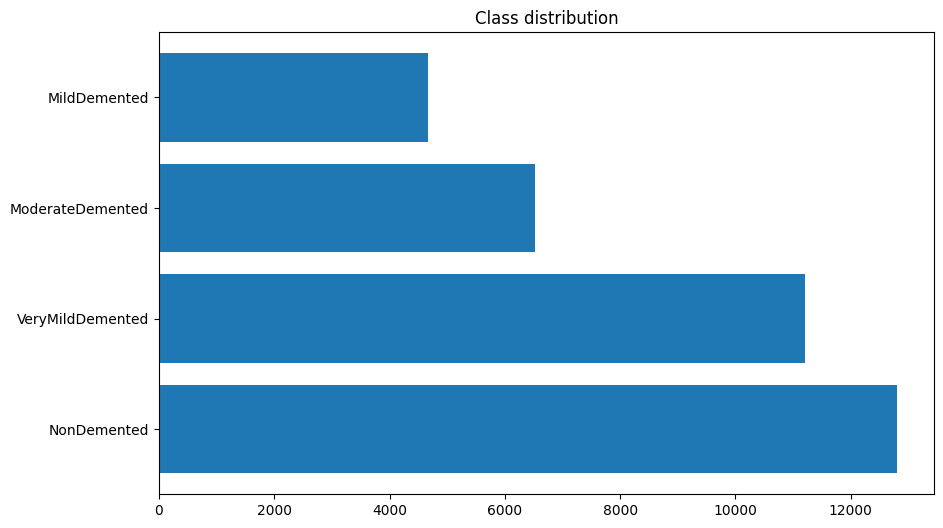

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
ax=plt.barh(label_count["label"], label_count["id"])
plt.title("Class distribution")
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10) 
plt.show()

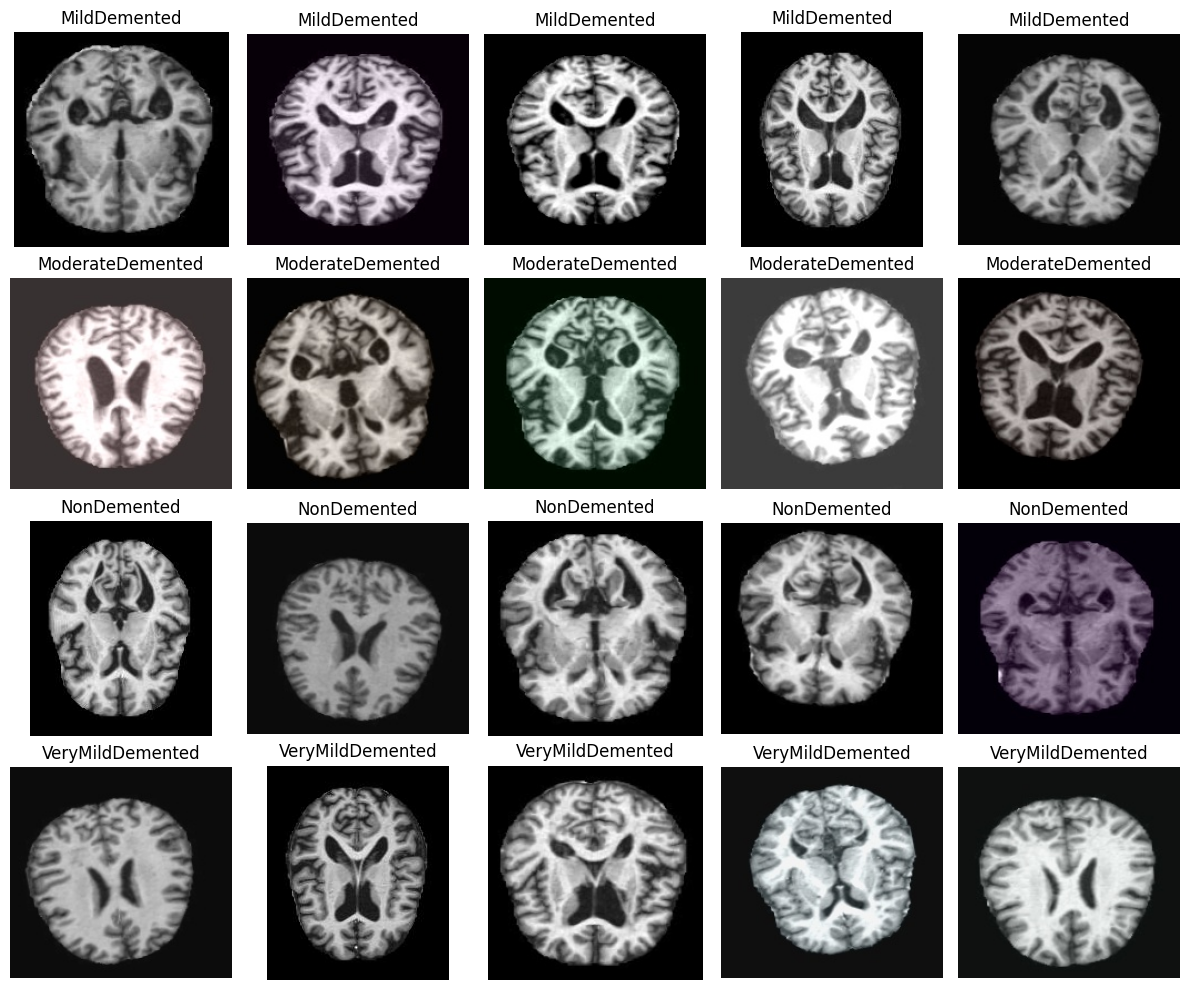

In [39]:
types = labels['label'].unique()
num_types = len(types)
num_images_per_type = 5

fig, axes = plt.subplots(num_types, num_images_per_type, figsize=(12, 2.5 * num_types))

for i, type_ in enumerate(types):
    subset = labels[labels['label'] == type_].head(num_images_per_type)
    
    for j, (idx, row) in enumerate(subset.iterrows()):
        img_path = row['id']
        
        img = mpimg.imread(img_path)
        axes[i, j].imshow(img, cmap=plt.get_cmap('gray'))
        axes[i, j].set_title(f"{row['label']}")
        axes[i, j].axis('off')
        

plt.tight_layout()
plt.show()

In [40]:
random.seed=42
train_indices=random.sample(list(range(len(labels))), int(len(labels)*0.8))
test_indices=[i for i in list(range(len(labels))) if i not in train_indices]

In [41]:
test_labels=labels.drop(train_indices).reset_index(drop=True)
test_labels

,id,label
0,/kaggle/input/medical-scan-classification-data...,MildDemented
1,/kaggle/input/medical-scan-classification-data...,MildDemented
2,/kaggle/input/medical-scan-classification-data...,MildDemented
3,/kaggle/input/medical-scan-classification-data...,MildDemented
4,/kaggle/input/medical-scan-classification-data...,MildDemented
...,...,...
7036,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
7037,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
7038,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
7039,/kaggle/input/medical-scan-classification-data...,VeryMildDemented


In [42]:
train_labels=labels.drop(test_indices).reset_index(drop=True)
train_labels

,id,label
0,/kaggle/input/medical-scan-classification-data...,MildDemented
1,/kaggle/input/medical-scan-classification-data...,MildDemented
2,/kaggle/input/medical-scan-classification-data...,MildDemented
3,/kaggle/input/medical-scan-classification-data...,MildDemented
4,/kaggle/input/medical-scan-classification-data...,MildDemented
...,...,...
28156,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
28157,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
28158,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
28159,/kaggle/input/medical-scan-classification-data...,VeryMildDemented


In [43]:
train_labels.to_csv('train_labels.csv',index=False)
test_labels.to_csv('test_labels.csv',index=False)

In [44]:
df_moderate = train_labels[train_labels['label'] == 'ModerateDemented']
df_verymild = train_labels[train_labels['label'] == 'VeryMildDemented']
df_mild = train_labels[train_labels['label'] == 'MildDemented']
df_non = train_labels[train_labels['label'] == 'NonDemented']
target_size = min(len(df_moderate), len(df_verymild), len(df_mild),len(df_non))
df_moderate_downsampled = df_moderate.sample(n=target_size, random_state=42)
df_verymild_downsampled = df_verymild.sample(n=target_size, random_state=42)
df_non_downsampled = df_non.sample(n=target_size, random_state=42)
balanced_train_data = pd.concat([df_moderate_downsampled, df_verymild_downsampled, df_non_downsampled, df_mild])
balanced_train_data = balanced_train_data.sample(frac=1)#shuffle(balanced_train_data, random_state=42)

balanced_train_data.to_csv("balanced_train_labels.csv", index=False)

In [45]:
balanced_train_data

,id,label
539,/kaggle/input/medical-scan-classification-data...,MildDemented
21713,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
22082,/kaggle/input/medical-scan-classification-data...,VeryMildDemented
3517,/kaggle/input/medical-scan-classification-data...,MildDemented
2720,/kaggle/input/medical-scan-classification-data...,MildDemented
...,...,...
15895,/kaggle/input/medical-scan-classification-data...,NonDemented
8401,/kaggle/input/medical-scan-classification-data...,ModerateDemented
13829,/kaggle/input/medical-scan-classification-data...,NonDemented
12487,/kaggle/input/medical-scan-classification-data...,NonDemented


In [46]:
label_count=balanced_train_data.groupby(by="label", as_index=False).count().sort_values(by="id", ascending=False).reset_index(drop=True)
label_count_test=test_labels.groupby(by="label", as_index=False).count().sort_values(by="id", ascending=False).reset_index(drop=True)
print("Label distribution is train data: \n", label_count[["label", "id"]], "\n")
print("Label distribution is test data: \n", label_count_test[["label", "id"]])

Label distribution is train data: 
               label    id
0      MildDemented  3746
1  ModerateDemented  3746
2       NonDemented  3746
3  VeryMildDemented  3746 

Label distribution is test data: 
               label    id
0       NonDemented  2571
1  VeryMildDemented  2296
2  ModerateDemented  1246
3      MildDemented   928


In [47]:
map_labels = dict()
for index, row in label_count.reset_index(drop=True).iterrows():
    map_labels[row["label"]] = index
    
print(len(map_labels))
map_labels

4


{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [48]:
inverse_map=dict()
for label in map_labels:
    inverse_map[map_labels[label]]=label
inverse_map

{0: 'MildDemented',
 1: 'ModerateDemented',
 2: 'NonDemented',
 3: 'VeryMildDemented'}

# Dataset functions

In [49]:
def grayscale_to_rgb(images):
    return np.repeat(images[..., np.newaxis], 3, axis=-1)

def grayscale_to_rgb_skimage(gray_image_array):
    """
    Converts a grayscale image loaded with scikit-image to an RGB image by duplicating 
    the grayscale values across R, G, and B channels.
    
    Parameters:
        gray_image_array (numpy.ndarray): A 2D array representing a grayscale image.
        
    Returns:
        numpy.ndarray: A 3D array representing an RGB image.
    """
    if gray_image_array.ndim != 2:
        raise ValueError("Input array must be a 2D grayscale image.")
    
    # Stack the grayscale channel across three channels (R, G, B)
    rgb_image_array = np.stack((gray_image_array,)*3, axis=-1)
    return rgb_image_array

In [50]:
class MRIDataset_train(Dataset):
    def __init__(self, csv_file, transform=None):
        self.labels = pd.read_csv(csv_file)
        #self.root_dir = root_dir
        self.transform = transform['train']
        #self.labels=csv_file
        
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, index):
        #img_path = os.path.join(self.root_dir, self.labels.iloc[index, 0])
        img_path=self.labels.iloc[index, 0]
        image = io.imread(img_path)
        y_label = torch.tensor(int(map_labels[self.labels.iloc[index, 1]]))


        if self.transform:
            image = self.transform(image)
        return (image, y_label)

In [4]:
class MRIDataset_test(Dataset):
    def __init__(self, csv_file, transform=None):
        self.name_images = pd.read_csv(csv_file)['id'].values
        #self.root_dir = root_dir
        self.transform = transform['test']
        self.labels=pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.name_images)
    
    def __getitem__(self, index):
        #img_path = os.path.join(self.root_dir, self.name_images[index])
        img_path=self.labels.iloc[index, 0]
        image = io.imread(img_path)
     
        if self.transform:
            image = self.transform(image)

        return image

In [7]:
transform ={'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])]),
    'test': transforms.Compose([transforms.ToPILImage(),
                                    transforms.Grayscale(3),
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])}


In [5]:
num_classes = 4
learning_rate = 1e-3
batch_size = 128
num_epochs = 25
lr_ratio=0.005

In [54]:
dataset = MRIDataset_train('/kaggle/working/balanced_train_labels.csv', transform)
train_set_size = int(len(dataset) * 0.8)
print("Train set length: ", train_set_size)
valid_set_size = len(dataset) - train_set_size
print("Validation set length: ", valid_set_size)
train_set, valid_set = torch.utils.data.random_split(dataset, [train_set_size, valid_set_size])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)

test_data = MRIDataset_test('/kaggle/working/test_labels.csv', transform=transform)
print("Test set length: ",len(test_data))
test_loader = DataLoader(test_data, batch_size=batch_size)

Train set length:  11987
Validation set length:  2997
Test set length:  7041


## Functions for training

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device")
print(device)

Device
cuda


In [57]:
# save checkpoint
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    torch.save(state, filename)

# load checkpint
def load_checkpoint(checkpoint, model, optimizer):
    print("Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scheduler = checkpoint['scheduler']

In [58]:
def plot_results(training_accuracy_list, training_loss_list, validation_accuracy_list, validation_loss_list):
    epochs = len(training_accuracy_list)
    x = np.arange(1, epochs + 1)

    training_accuracy_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in training_accuracy_list]
    training_loss_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in training_loss_list]
    validation_accuracy_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in validation_accuracy_list]
    best_loss_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in validation_loss_list]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(x, training_accuracy_list, label='Training Accuracy', color='blue')
    axes[1].plot(x, training_loss_list, label='Training Loss', color='orange')
    axes[0].plot(x, validation_accuracy_list, label='Validation Accuracy', color='green')
    axes[1].plot(x, best_loss_list, label='Validation Loss', color='red')

    fig.suptitle('Model Evaluation Metrics')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    axes[0].grid(True)
    axes[1].set_xlabel('Epochs')
    axes[1].legend()
    axes[1].grid(True)
    plt.show()

In [59]:
def traindata(device, model, epochs, optimizer, scheduler, loss_function, train_loader, valid_loader, filename):
    # Early stopping
    best_loss = 100
    current_loss=100
    patience = 5
    trigger_times = 0

    # Lists to store data for plotting
    training_accuracy_list = []
    training_loss_list = []
    best_loss_list = []
    validation_accuracy_list = []
    validation_loss_list = []

    for epoch in range(1, epochs+1):
        model.train()
        correct = 0
        loss_total = 0
        for data in train_loader:
            input = data[0].to(device)
            label = data[1].to(device)

            optimizer.zero_grad()

            output = model(input)
            _, predicted = output.max(1)
            loss = loss_function(output, label)
            loss_total += loss.item()
            correct+= (predicted == label).sum()
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

        training_accuracy = correct/len(train_loader.sampler)
        training_loss = loss_total/len(train_loader)

        print('{}. epoch'.format(epoch))
        

         # Early stopping
        current_loss, validation_accuracy = validation(model, device, valid_loader, loss_function)
        print('Training accuracy: {} Training loss: {} \nValidation accuracy: {} Validation loss: {}'.format(training_accuracy, training_loss, validation_accuracy, current_loss))

        # Append values to lists for plotting
        training_accuracy_list.append(training_accuracy)
        training_loss_list.append(training_loss)
        validation_accuracy_list.append(validation_accuracy)
        validation_loss_list.append(current_loss)
        best_loss_list.append(best_loss)

        if current_loss > best_loss:
            trigger_times += 1

            if trigger_times >= patience:
                print('Early stopping! Start to test process.')
                break
        else:
            trigger_times = 0
            save_checkpoint(checkpoint, filename)
            best_loss = current_loss

    # Plot the results
    plot_results(training_accuracy_list, training_loss_list, validation_accuracy_list, validation_loss_list)

    return model

In [60]:
def validation(model, device, valid_loader, loss_function):

    model.eval()
    loss_total = 0
    correct = 0
    
    with torch.no_grad():
        for data in valid_loader:
            input = data[0].to(device)
            label = data[1].to(device)
            output = model(input)
            _, predicted = output.max(1)
            loss = loss_function(output, label)
            loss_total += loss.item()
            correct+= (predicted == label).sum()
        validation_accuracy = correct/len(valid_loader.sampler)
    return loss_total / len(valid_loader), validation_accuracy

In [8]:
def test(device, model, test_loader, loss_function):
    model.eval()
    predictions = pd.DataFrame()
    with torch.no_grad():
        for data in test_loader:
            input = data.to(device)
            output = model(input)
            m = nn.Softmax(dim=1)
            res = m(output)
            predictions = pd.concat([predictions, pd.DataFrame(torch.Tensor.cpu(res).numpy(), columns = list(map_labels.keys()))], ignore_index=True)
        return (predictions)

# ResNet50

In [62]:
model_resnet = models.resnet50(pretrained=True)

for param in model_resnet.parameters():
    param.requires_grad = False
    
model_resnet.fc = nn.Linear(2048, num_classes) 
model_resnet = model_resnet.to(device=device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s] 


In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_resnet.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

1. epoch
Training accuracy: 0.5058813691139221 Training loss: 1.1714219368518668 
Validation accuracy: 0.5578912496566772 Validation loss: 1.0462678124507268
2. epoch
Training accuracy: 0.6085759401321411 Training loss: 0.9627925252660792 
Validation accuracy: 0.6082749366760254 Validation loss: 0.9332535564899445
3. epoch
Training accuracy: 0.6294318437576294 Training loss: 0.8964721370250621 
Validation accuracy: 0.6289622783660889 Validation loss: 0.8837358206510544
4. epoch
Training accuracy: 0.63744056224823 Training loss: 0.8684993741360116 
Validation accuracy: 0.639639675617218 Validation loss: 0.8701381981372833
5. epoch
Training accuracy: 0.6573787927627563 Training loss: 0.8305067990688567 
Validation accuracy: 0.6413080096244812 Validation loss: 0.8392152537902197
6. epoch
Training accuracy: 0.6634687185287476 Training loss: 0.8108615076288264 
Validation accuracy: 0.6423090100288391 Validation loss: 0.8312911416093508
7. epoch
Training accuracy: 0.6780678629875183 Training

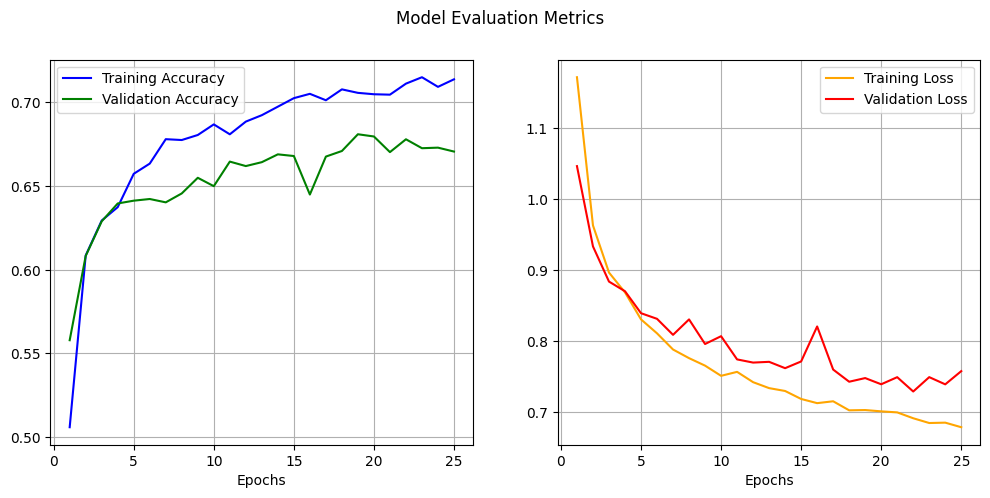

In [64]:
model = traindata(device, model_resnet, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "resnet_checkpoint.pth.tar")

1. epoch
Training accuracy: 0.7139400839805603 Training loss: 0.7176804745450933 
Validation accuracy: 0.7173840403556824 Validation loss: 0.6784038295348486
2. epoch
Training accuracy: 0.868273913860321 Training loss: 0.32630417369147563 
Validation accuracy: 0.7967967987060547 Validation loss: 0.47079940388600033
3. epoch
Training accuracy: 0.9231667518615723 Training loss: 0.2015157624920632 
Validation accuracy: 0.9142475724220276 Validation loss: 0.21865646944691738
4. epoch
Training accuracy: 0.956202507019043 Training loss: 0.12230110009934039 
Validation accuracy: 0.9079079031944275 Validation loss: 0.2258483124896884
5. epoch
Training accuracy: 0.9679652452468872 Training loss: 0.08642943248033841 
Validation accuracy: 0.8221554756164551 Validation loss: 0.5863111640016238


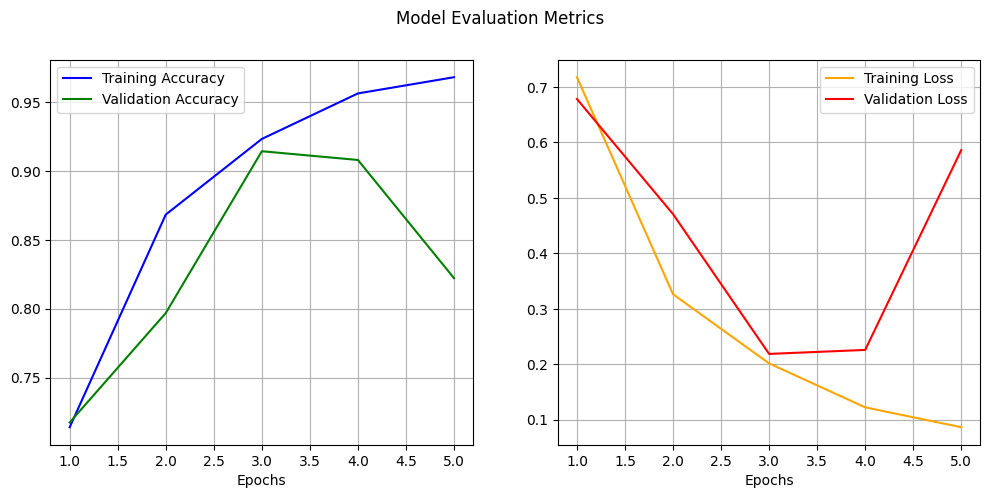

In [65]:
# fine tuning
for param in model_resnet.parameters():
    param.requires_grad = True

resnet_model = traindata(device, model_resnet, 5, optimizer, scheduler, criterion, train_loader, valid_loader, "resnet_checkpoint_finetuned.pth.tar")

In [66]:
load_checkpoint(torch.load("resnet_checkpoint_finetuned.pth.tar"), model_resnet, optimizer)

/tmp/ipykernel_30/2535006145.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("resnet_checkpoint_finetuned.pth.tar"), model_resnet, optimizer)


Loading checkpoint


In [67]:
df = test(device, resnet_model, test_loader, criterion)
df=pd.concat([df, test_labels["label"]], axis=1)
df["pred"]=df[["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]].idxmax(axis=1)#.astype(np.int64)
df.to_csv('resnet50_finetuned.csv', index=False)
df

,MildDemented,ModerateDemented,NonDemented,VeryMildDemented,label,pred
0,0.999819,2.753679e-07,0.000124,0.000057,MildDemented,MildDemented
1,0.996125,1.492425e-07,0.002760,0.001115,MildDemented,MildDemented
2,0.999390,6.306325e-07,0.000459,0.000150,MildDemented,MildDemented
3,0.230124,1.361410e-06,0.316454,0.453420,MildDemented,VeryMildDemented
4,0.249082,4.680396e-07,0.100227,0.650690,MildDemented,VeryMildDemented
...,...,...,...,...,...,...
7036,0.000293,4.998221e-08,0.003253,0.996454,VeryMildDemented,VeryMildDemented
7037,0.001540,1.000390e-07,0.011694,0.986766,VeryMildDemented,VeryMildDemented
7038,0.019119,1.068626e-07,0.087942,0.892938,VeryMildDemented,VeryMildDemented
7039,0.279809,2.703431e-07,0.141835,0.578355,VeryMildDemented,VeryMildDemented


In [68]:
print("Test accuracy is: ", accuracy_score(df["label"], df["pred"]))

Test accuracy is:  0.8987359750035506


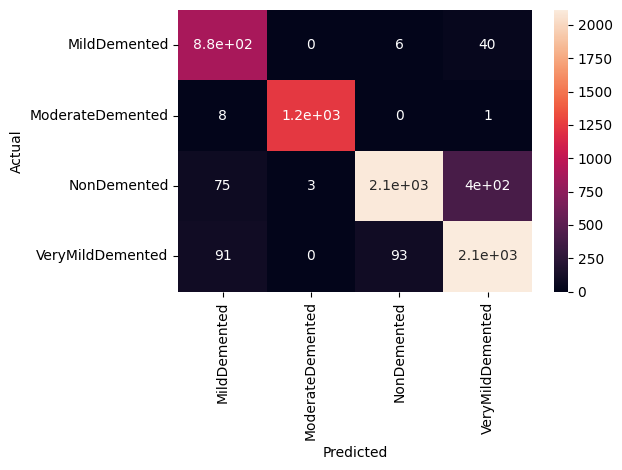

In [69]:
conf_matrix = confusion_matrix(df["label"], df["pred"])
ax=sns.heatmap(conf_matrix, annot=True)
ax.set(xlabel="Predicted", ylabel="Actual")
ax.xaxis.set_ticklabels(["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"], rotation=90)
ax.yaxis.set_ticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

# VGG16

In [70]:
# Load the VGG16 model
model_vgg = models.vgg16(pretrained=True)

# Freeze the parameters
for param in model_vgg.parameters():
    param.requires_grad = False

# Replace the last layer to match the number of classes
model_vgg.classifier[6] = nn.Linear(4096, num_classes) # number of classes
model_vgg = model_vgg.to(device=device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 221MB/s] 


In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_vgg.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

1. epoch
Training accuracy: 0.4318845272064209 Training loss: 1.2328431048291795 
Validation accuracy: 0.5228561758995056 Validation loss: 1.0634668966134389
2. epoch
Training accuracy: 0.5071327090263367 Training loss: 1.0899804545209764 
Validation accuracy: 0.5615615844726562 Validation loss: 0.996216264863809
3. epoch
Training accuracy: 0.533661425113678 Training loss: 1.0446996492274263 
Validation accuracy: 0.5932599306106567 Validation loss: 0.9454167361060778
4. epoch
Training accuracy: 0.5453407764434814 Training loss: 1.0212271790555183 
Validation accuracy: 0.5969302654266357 Validation loss: 0.9297815809647242
5. epoch
Training accuracy: 0.5487611293792725 Training loss: 1.0074800075368677 
Validation accuracy: 0.5892559289932251 Validation loss: 0.923602449397246
6. epoch
Training accuracy: 0.5505130290985107 Training loss: 1.002278116155178 
Validation accuracy: 0.586586594581604 Validation loss: 0.9176774000128111
7. epoch
Training accuracy: 0.5586885809898376 Training l

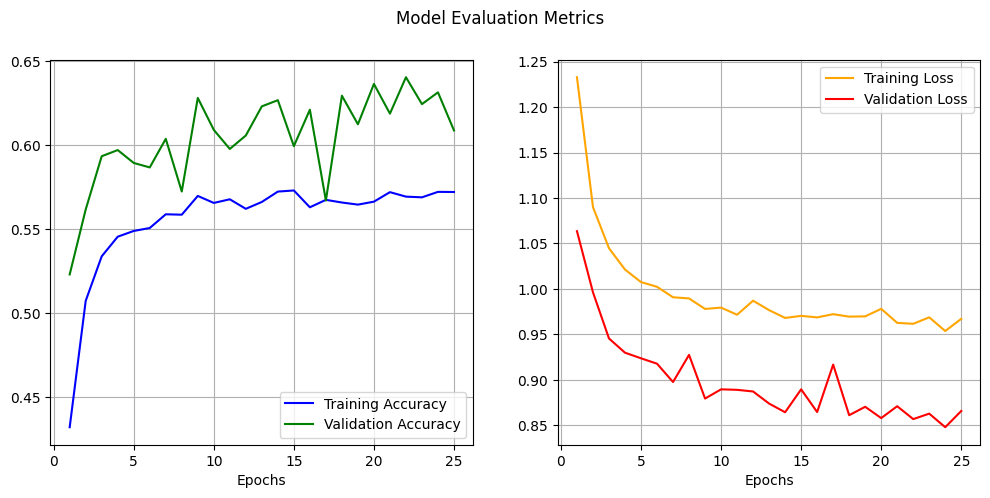

In [72]:
vgg = traindata(device, model_vgg, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "vgg_checkpoint.pth.tar")

1. epoch
Training accuracy: 0.25886377692222595 Training loss: 3.4460589594029365 
Validation accuracy: 0.26259592175483704 Validation loss: 1.3928876171509426
2. epoch
Training accuracy: 0.2562776207923889 Training loss: 1.3924829845732831 
Validation accuracy: 0.28028029203414917 Validation loss: 1.3794239362080891
3. epoch
Training accuracy: 0.27162760496139526 Training loss: 1.3841666173427662 
Validation accuracy: 0.30096763372421265 Validation loss: 1.3643444677193959
4. epoch
Training accuracy: 0.2900642156600952 Training loss: 1.3820337107841005 
Validation accuracy: 0.3727060556411743 Validation loss: 1.303878699739774
5. epoch
Training accuracy: 0.33803287148475647 Training loss: 1.346698376726597 
Validation accuracy: 0.24657991528511047 Validation loss: 1.3859774271647136


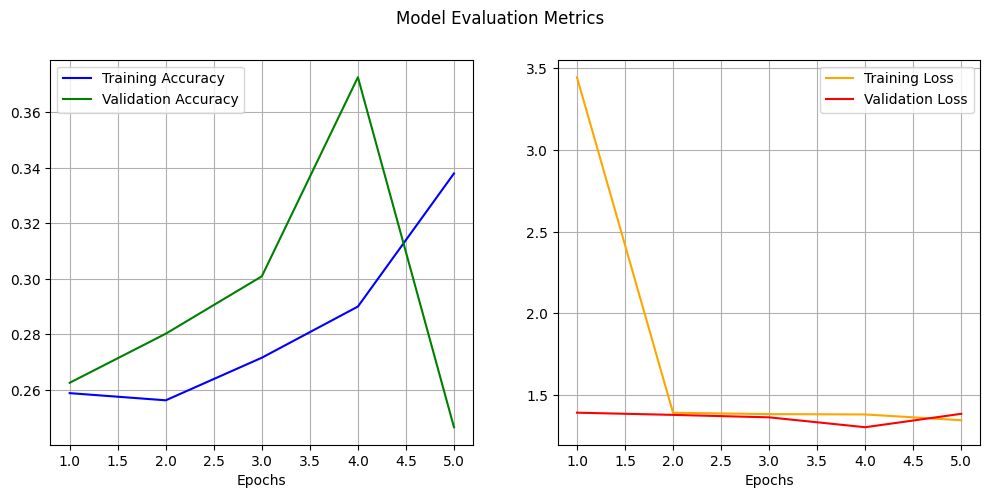

In [73]:
# finetuning
for param in model_vgg.parameters():
    param.requires_grad = True

vgg2 = traindata(device, model_vgg, 5, optimizer, scheduler, criterion, train_loader, valid_loader, "vgg_checkpoint_finetuned.pth.tar")

In [74]:
load_checkpoint(torch.load("vgg_checkpoint_finetuned.pth.tar"), model_vgg, optimizer)

/tmp/ipykernel_30/2415708443.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("vgg_checkpoint_finetuned.pth.tar"), model_vgg, optimizer)


Loading checkpoint


In [75]:
df = test(device, vgg2, test_loader, criterion)
df=pd.concat([df, test_labels["label"]], axis=1)
df["pred"]=df[["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]].idxmax(axis=1)#.astype(np.int64)
df.to_csv('vgg_finetuned.csv', index=False)
df

,MildDemented,ModerateDemented,NonDemented,VeryMildDemented,label,pred
0,0.376099,0.406278,0.089353,0.128270,MildDemented,ModerateDemented
1,0.255529,0.138623,0.324547,0.281301,MildDemented,NonDemented
2,0.256582,0.214610,0.259811,0.268998,MildDemented,VeryMildDemented
3,0.278621,0.275461,0.200386,0.245532,MildDemented,MildDemented
4,0.245618,0.124851,0.342824,0.286707,MildDemented,NonDemented
...,...,...,...,...,...,...
7036,0.243647,0.134969,0.335118,0.286266,VeryMildDemented,NonDemented
7037,0.266095,0.237048,0.236235,0.260621,VeryMildDemented,MildDemented
7038,0.270300,0.249983,0.224459,0.255258,VeryMildDemented,MildDemented
7039,0.312705,0.444312,0.100879,0.142103,VeryMildDemented,ModerateDemented


In [76]:
print("Test accuracy is: ", accuracy_score(df["label"], df["pred"]))

Test accuracy is:  0.3787814230933106


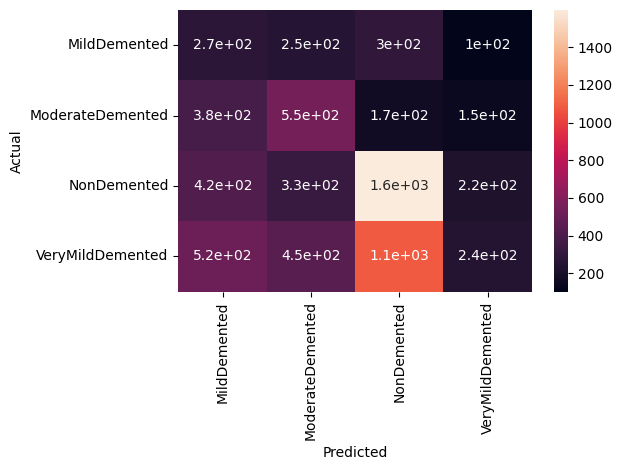

In [77]:
conf_matrix = confusion_matrix(df["label"], df["pred"])
ax=sns.heatmap(conf_matrix, annot=True)
ax.set(xlabel="Predicted", ylabel="Actual")
ax.xaxis.set_ticklabels(["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"], rotation=90)
ax.yaxis.set_ticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

# EfficientNet

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 134MB/s] 


1. epoch
Training accuracy: 0.5030449628829956 Training loss: 1.1698256883215397 
Validation accuracy: 0.579245924949646 Validation loss: 1.0343070551753044
2. epoch
Training accuracy: 0.5888045430183411 Training loss: 1.003969523500889 
Validation accuracy: 0.6106106042861938 Validation loss: 0.9340484688679377
3. epoch
Training accuracy: 0.6047384738922119 Training loss: 0.9460703121854904 
Validation accuracy: 0.6336336135864258 Validation loss: 0.8833667809764544
4. epoch
Training accuracy: 0.6184199452400208 Training loss: 0.9062512960839779 
Validation accuracy: 0.6459793448448181 Validation loss: 0.8459938019514084
5. epoch
Training accuracy: 0.6203386783599854 Training loss: 0.8849249469473007 
Validation accuracy: 0.6509843468666077 Validation loss: 0.8332298869887987
6. epoch
Training accuracy: 0.6360223293304443 Training loss: 0.8642598783716242 
Validation accuracy: 0.6519853472709656 Validation loss: 0.8189082940419515
7. epoch
Training accuracy: 0.6417785882949829 Trainin

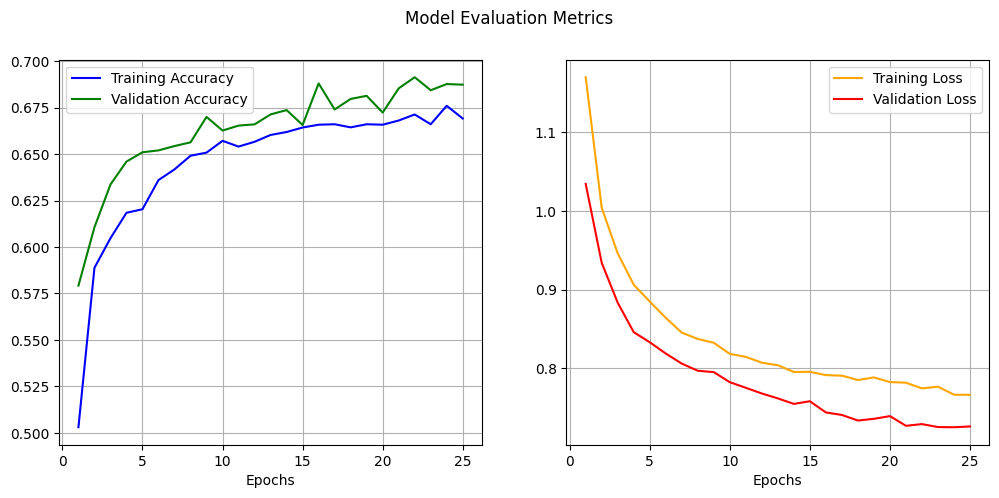

In [78]:
num_epochs=25

# Load the EfficientNet-B0 model
model_efficientnet2 = models.efficientnet_b0(pretrained=True)

# Freeze the parameters
for param in model_efficientnet2.parameters():
    param.requires_grad = False

# Replace the classifier to match the number of classes
model_efficientnet2.classifier[1] = nn.Linear(model_efficientnet2.classifier[1].in_features, num_classes)

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_efficientnet2 = model_efficientnet2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficientnet2.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_efficientnet2.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

model_eff2 = traindata(device, model_efficientnet2, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "effnet_checkpoint_2.pth.tar")

1. epoch
Training accuracy: 0.7400516867637634 Training loss: 0.5936842979268825 
Validation accuracy: 0.8425092101097107 Validation loss: 0.36770643790562946
2. epoch
Training accuracy: 0.8991407155990601 Training loss: 0.251483429223299 
Validation accuracy: 0.9379379749298096 Validation loss: 0.15541756308327118
3. epoch
Training accuracy: 0.9605405926704407 Training loss: 0.10901327732395619 
Validation accuracy: 0.9589589834213257 Validation loss: 0.10210361424833536
4. epoch
Training accuracy: 0.9721364378929138 Training loss: 0.07684899658519537 
Validation accuracy: 0.965965986251831 Validation loss: 0.0888123451732099
5. epoch
Training accuracy: 0.9852339625358582 Training loss: 0.045965756725599154 
Validation accuracy: 0.9532866477966309 Validation loss: 0.13386648148298264


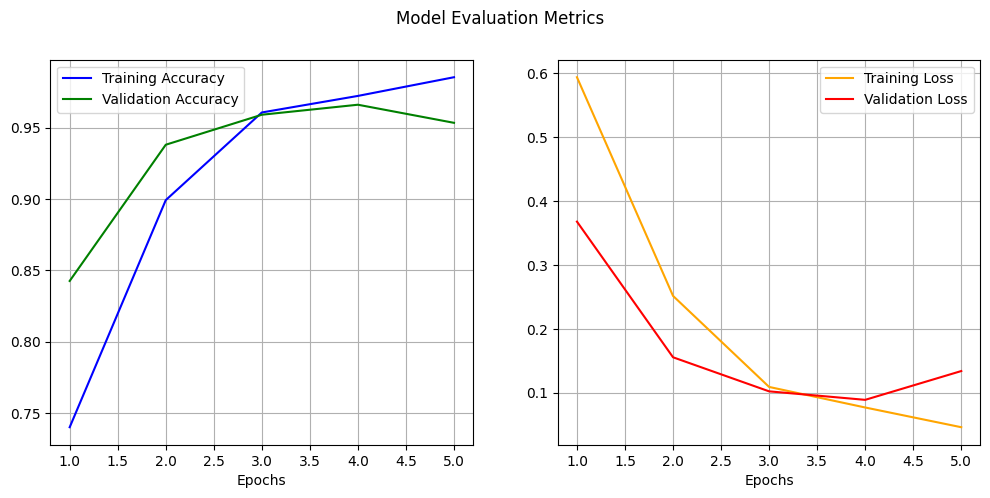

In [79]:
# fine tuning
for param in model_efficientnet2.parameters():
    param.requires_grad = True

model_eff2 = traindata(device, model_efficientnet2, 5, optimizer, scheduler, criterion, train_loader, valid_loader, "effnet_checkpoint_finetuned.pth.tar")

In [80]:
load_checkpoint(torch.load("effnet_checkpoint_finetuned.pth.tar"), model_efficientnet2, optimizer)

Loading checkpoint


/tmp/ipykernel_30/2128675062.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("effnet_checkpoint_finetuned.pth.tar"), model_efficientnet2, opti

In [81]:
df = test(device, model_eff2, test_loader, criterion)
df=pd.concat([df, test_labels["label"]], axis=1)
df["pred"]=df[["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]].idxmax(axis=1)#.astype(np.int64)
df.to_csv('efficientnet_finetuned.csv', index=False)
df

,MildDemented,ModerateDemented,NonDemented,VeryMildDemented,label,pred
0,0.999614,5.259006e-07,7.139037e-06,3.784658e-04,MildDemented,MildDemented
1,0.999934,1.133107e-09,5.458074e-05,1.141922e-05,MildDemented,MildDemented
2,1.000000,1.693246e-11,5.446170e-10,4.973301e-08,MildDemented,MildDemented
3,0.996311,3.790578e-10,1.705028e-05,3.672241e-03,MildDemented,MildDemented
4,0.999996,8.975013e-11,1.630599e-06,2.506923e-06,MildDemented,MildDemented
...,...,...,...,...,...,...
7036,0.000058,2.329517e-04,2.013694e-03,9.976949e-01,VeryMildDemented,VeryMildDemented
7037,0.000012,1.249987e-05,3.871359e-04,9.995881e-01,VeryMildDemented,VeryMildDemented
7038,0.000005,1.228151e-07,3.782633e-03,9.962126e-01,VeryMildDemented,VeryMildDemented
7039,0.000012,1.356416e-09,1.186896e-04,9.998690e-01,VeryMildDemented,VeryMildDemented


In [82]:
print("Test accuracy is: ", accuracy_score(df["label"], df["pred"]))

Test accuracy is:  0.9502911518250249


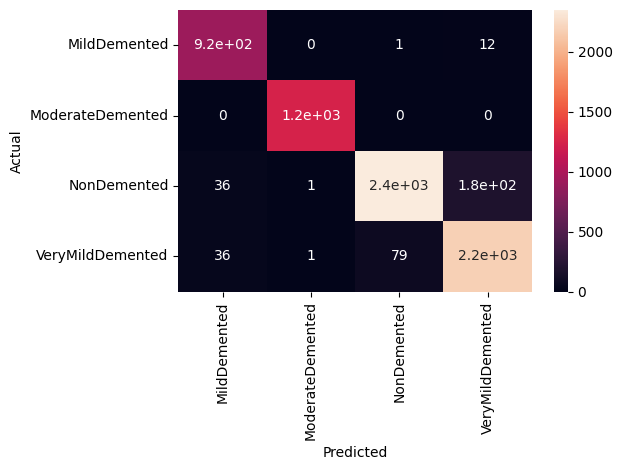

In [83]:
conf_matrix = confusion_matrix(df["label"], df["pred"])
ax=sns.heatmap(conf_matrix, annot=True)
ax.set(xlabel="Predicted", ylabel="Actual")
ax.xaxis.set_ticklabels(["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"], rotation=90)
ax.yaxis.set_ticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

# MobileNetV2

In [84]:
# Load the MobileNetV2 model
model_mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze the parameters
for param in model_mobilenet.parameters():
    param.requires_grad = False

# Replace the classifier to match the number of classes
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.last_channel, num_classes)

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_mobilenet = model_mobilenet.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 123MB/s]


In [85]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mobilenet.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_mobilenet.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

1. epoch
Training accuracy: 0.5027946829795837 Training loss: 1.1439822937579864 
Validation accuracy: 0.5742409229278564 Validation loss: 1.0155897215008736
2. epoch
Training accuracy: 0.5968132019042969 Training loss: 0.9654097506340514 
Validation accuracy: 0.6149482727050781 Validation loss: 0.9310631180802981
3. epoch
Training accuracy: 0.6255109310150146 Training loss: 0.8999055129416446 
Validation accuracy: 0.6282949447631836 Validation loss: 0.878892091413339
4. epoch
Training accuracy: 0.6348544359207153 Training loss: 0.8640944425095903 
Validation accuracy: 0.6423090100288391 Validation loss: 0.8519961188236872
5. epoch
Training accuracy: 0.6399432420730591 Training loss: 0.8439947969101845 
Validation accuracy: 0.6456456780433655 Validation loss: 0.8322561904788017
6. epoch
Training accuracy: 0.6597146987915039 Training loss: 0.8150966408404898 
Validation accuracy: 0.6419753432273865 Validation loss: 0.8200533588727316
7. epoch
Training accuracy: 0.6590473055839539 Traini

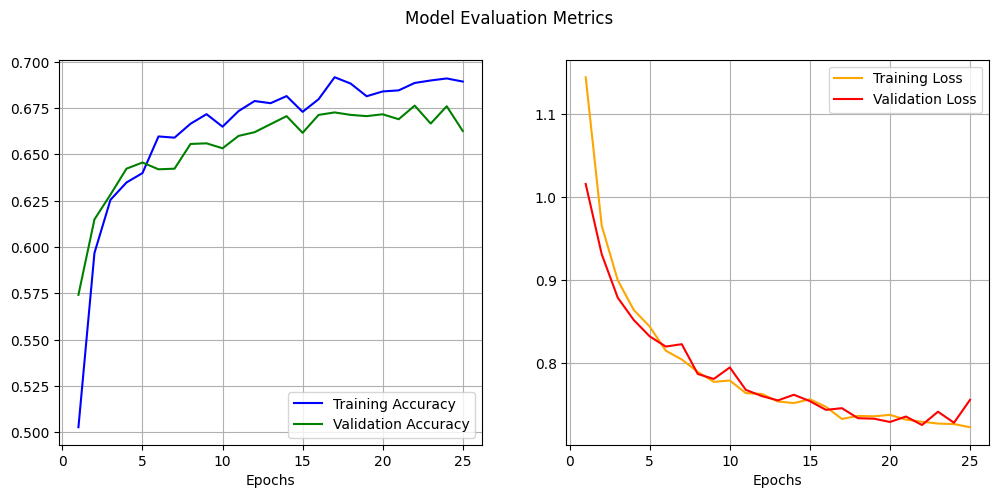

In [86]:
model_mob = traindata(device, model_mobilenet, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "mobnet_checkpoint.pth.tar")

1. epoch
Training accuracy: 0.7336280941963196 Training loss: 0.6220685975982788 
Validation accuracy: 0.6463130116462708 Validation loss: 1.0302117466926575
2. epoch
Training accuracy: 0.8822057247161865 Training loss: 0.2946283882285686 
Validation accuracy: 0.8988988995552063 Validation loss: 0.24598860119779906
3. epoch
Training accuracy: 0.9330107569694519 Training loss: 0.1750506391709155 
Validation accuracy: 0.9269269108772278 Validation loss: 0.18932139035314322
4. epoch
Training accuracy: 0.9682989716529846 Training loss: 0.08461945882423762 
Validation accuracy: 0.9396063089370728 Validation loss: 0.18587974489976963
5. epoch
Training accuracy: 0.9747225642204285 Training loss: 0.07079469566134379 
Validation accuracy: 0.890890896320343 Validation loss: 0.3201223087186615


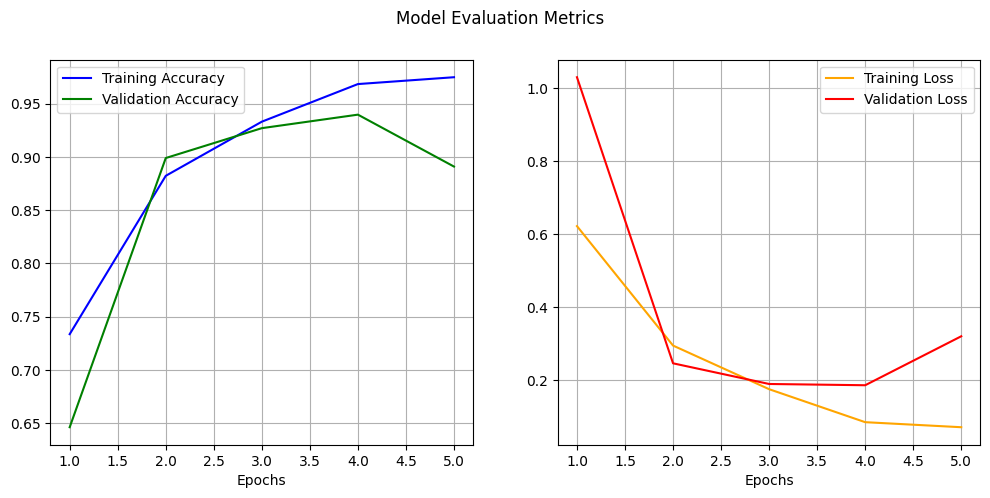

In [87]:
# fine tuning
for param in model_mobilenet.parameters():
    param.requires_grad = True

model_mob2 = traindata(device, model_mobilenet, 5, optimizer, scheduler, criterion, train_loader, valid_loader, "mobnet_checkpoint_finetuned.pth.tar")

In [88]:
load_checkpoint(torch.load("mobnet_checkpoint_finetuned.pth.tar"), model_mobilenet, optimizer)

Loading checkpoint


/tmp/ipykernel_30/1158555411.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("mobnet_checkpoint_finetuned.pth.tar"), model_mobilenet, optimize

In [89]:
df = test(device, model_mob2, test_loader, criterion)
df=pd.concat([df, test_labels["label"]], axis=1)
df["pred"]=df[["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]].idxmax(axis=1)#.astype(np.int64)
df.to_csv('mobilenet_finetuned.csv', index=False)
df

,MildDemented,ModerateDemented,NonDemented,VeryMildDemented,label,pred
0,0.999995,3.778388e-07,2.752814e-06,0.000001,MildDemented,MildDemented
1,0.999954,1.437879e-10,1.575660e-05,0.000030,MildDemented,MildDemented
2,0.999992,1.911217e-08,5.541684e-08,0.000008,MildDemented,MildDemented
3,0.999744,2.021440e-06,1.107300e-04,0.000143,MildDemented,MildDemented
4,0.999995,2.315971e-09,1.674605e-06,0.000003,MildDemented,MildDemented
...,...,...,...,...,...,...
7036,0.004403,3.282473e-05,7.452212e-02,0.921042,VeryMildDemented,VeryMildDemented
7037,0.000041,2.398162e-08,1.542626e-02,0.984533,VeryMildDemented,VeryMildDemented
7038,0.000022,2.707974e-10,3.058771e-02,0.969390,VeryMildDemented,VeryMildDemented
7039,0.003242,8.462532e-08,3.231194e-02,0.964446,VeryMildDemented,VeryMildDemented


In [90]:
print("Test accuracy is: ", accuracy_score(df["label"], df["pred"]))

Test accuracy is:  0.9278511575060361


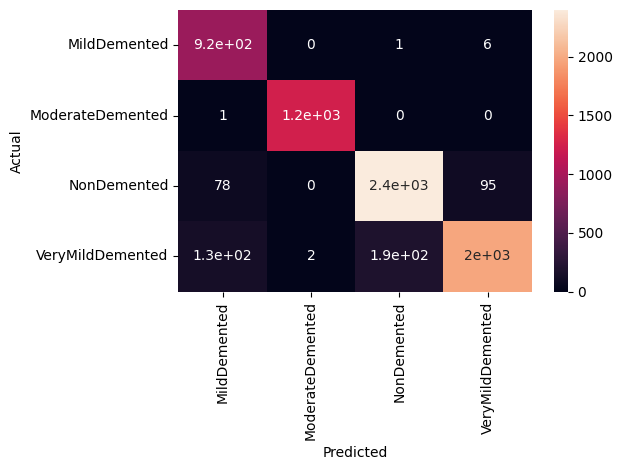

In [91]:
conf_matrix = confusion_matrix(df["label"], df["pred"])
ax=sns.heatmap(conf_matrix, annot=True)
ax.set(xlabel="Predicted", ylabel="Actual")
ax.xaxis.set_ticklabels(["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"], rotation=90)
ax.yaxis.set_ticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

# Evaluation

In [13]:
resnet50=pd.read_csv("/kaggle/input/predictions/resnet50_finetuned.csv")
effnet=pd.read_csv("/kaggle/input/predictions/efficientnet_finetuned.csv")
mobnet=pd.read_csv("/kaggle/input/predictions/mobilenet_finetuned.csv")
vgg=pd.read_csv("/kaggle/input/predictions/vgg_finetuned.csv")

In [18]:
def top_p_percent_acc(data, p):
    cat_num=len(list(data.columns))-2  #number of categories = number of columns - 2 (number of picture, true_label)
    test_size=len(list(data.index)) #number of validation data points
    p_percent=int(p/100*cat_num) #p percent of the validation size
    acc=0
    for row,i in data.iterrows():
        best_p_indices=np.array(i[:len(i)-2]).argsort()[-p_percent:][::-1]  #the p% largest probabilities
        best_p_columns=[data.columns[j] for j in best_p_indices]  #the corresponding classes
        true_label=str(i["label"]) #str(train.loc[i["picture"],"landmark_id"])  #the true class of the data point
        if true_label in best_p_columns:
            acc+=1
    acc=acc/test_size
    return acc

In [19]:
def top_p_percent_plot(data, P_list):
    cat_num=len(list(data.columns))-2  #number of categories = number of columns - 2 (number of picture, true_label)
    test_size=len(list(data.index)) #number of validation data points

    values=[]
    for p in P_list:
        acc=top_p_percent_acc(data, p)
        values.append(acc)

    plt.plot(P_list, values, color="green")
    plt.title('P-percent accuracies')
    plt.xlabel('P values')
    plt.ylabel('P-Accuracy')
    #plt.ylim([-0.05, 1.05])

    plt.show()

In [20]:
def multiple_data_ppercent(l):
    cat_num=len(list(l[0][0].columns))-2 
    test_size=len(list(l[0][0].index))
    for i in l:
        data, P_list, name = i
        values=[]
        for p in P_list:
            acc=top_p_percent_acc(data, p)
            values.append(acc)
        plt.plot(P_list, values, label=name)
    plt.title('P-percent accuracies')
    plt.xlabel('P values')
    plt.ylabel('P-Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

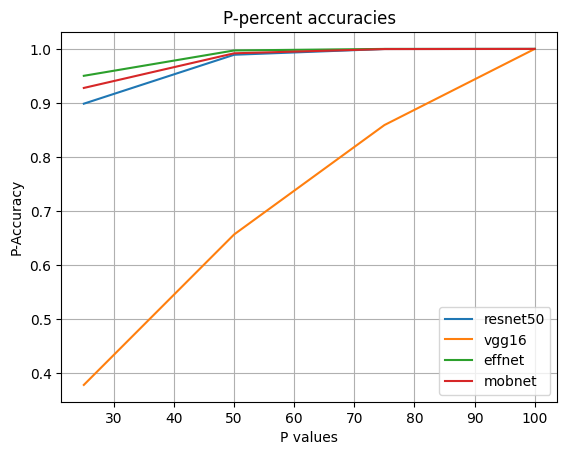

In [21]:
p=[25, 50, 75, 100]
multiple_data_ppercent([[resnet50, p, "resnet50"], [vgg, p, "vgg16"], [effnet, p, "effnet"], [mobnet, p, "mobnet"]])

In [ ]:
# we needed this just because the class sizes weren't balanced before

def acc_class_size(data, title):  #we would like to investigate if the the accuracy and the size of the class are correlated
    accuracies=[] #this list will contain the accuracies of the classes
    sizes=[]
    for class_name in data.columns[:len(data.columns)-1]:
        class_data=data[data["label"]==str(class_name)] #validation data points from this class
        acc=top_p_percent_acc(class_data, 2)    #accuracy of the validation data from this class
        accuracies.append(acc)
        class_size=labels[labels["label"]==class_name]["id"].values[0]
        sizes.append(class_size)
    order=np.array(accuracies).argsort() #order the two list according to the accuracies
    accuracies=[accuracies[i] for i in order]
    sizes=[sizes[i] for i in order]
    sizes=[(sizes[i]-min(sizes))/(max(sizes)-min(sizes)) for i in range(len(sizes))] #normalize the sizes into [0, 1]
    corr=round(np.corrcoef(accuracies, sizes)[0, 1],4)
    label="corr="+str(corr)
    plt.scatter(accuracies, sizes, label=label)
    plt.title(title)
    plt.ylabel("Size of the class")
    plt.xlabel("Accuracy of the class")
    plt.legend()
    plt.show()

In [ ]:
acc_class_size(resnet50, "Resnet50")
acc_class_size(vgg, "VGG16")
acc_class_size(mobnet, "MobileNet")
acc_class_size(effnet, "EfficientNet")